In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [34]:
N = 6 

df = pd.read_csv('../datasets/students_simple.csv')

col1_idx = N % 5
col2_idx = (N**2) % 5 + 5

col1_name = df.columns[col1_idx]
col2_name = df.columns[col2_idx]

x = df[col1_name].values
y = df[col2_name].values

print(f"Полученные столбцы: '{col1_name}' (X) и '{col2_name}' (Y)")

Полученные столбцы: 'mass' (X) и 'bmi' (Y)


In [35]:
# 1. РАСЧЕТ КОРРЕЛЯЦИЙ

# 1.1 Корреляция Фехнера
x_med = np.median(x)
y_med = np.median(y)
signs_x = np.sign(x - x_med)
signs_y = np.sign(y - y_med)

C = np.sum(signs_x == signs_y) 
H = np.sum(signs_x != signs_y) 
fechner_corr = (C - H) / (C + H)
print(f"Корреляция Фехнера: {fechner_corr:.4f}")

# 1.2 Корреляция Пирсона и доверительный интервал
pearson_corr, p_value_pearson = stats.pearsonr(x, y)
print(f"Корреляция Пирсона: {pearson_corr:.4f} (p-value: {p_value_pearson:.4e})")

n = len(x)
# Преобразование Фишера
z = np.arctanh(pearson_corr)
se = 1 / np.sqrt(n - 3)
z_critical = stats.norm.ppf(0.975) 
ci_low, ci_high = np.tanh(z - z_critical * se), np.tanh(z + z_critical * se)
print(f"95% Доверительный интервал для Пирсона: [{ci_low:.4f}, {ci_high:.4f}]")

# 1.3 Корреляция Спирмена
spearman_corr, p_value_spearman = stats.spearmanr(x, y)
print(f"Корреляция Спирмена: {spearman_corr:.4f} (p-value: {p_value_spearman:.4e})")

# 1.4 Корреляция Кенделла
kendall_corr, p_value_kendall = stats.kendalltau(x, y)
print(f"Корреляция Кенделла: {kendall_corr:.4f} (p-value: {p_value_kendall:.4e})")

Корреляция Фехнера: -1.0000
Корреляция Пирсона: -0.9606 (p-value: 1.8792e-11)
95% Доверительный интервал для Пирсона: [-0.9846, -0.9012]
Корреляция Спирмена: -0.9849 (p-value: 3.5722e-15)
Корреляция Кенделла: -0.9390 (p-value: 8.8353e-09)


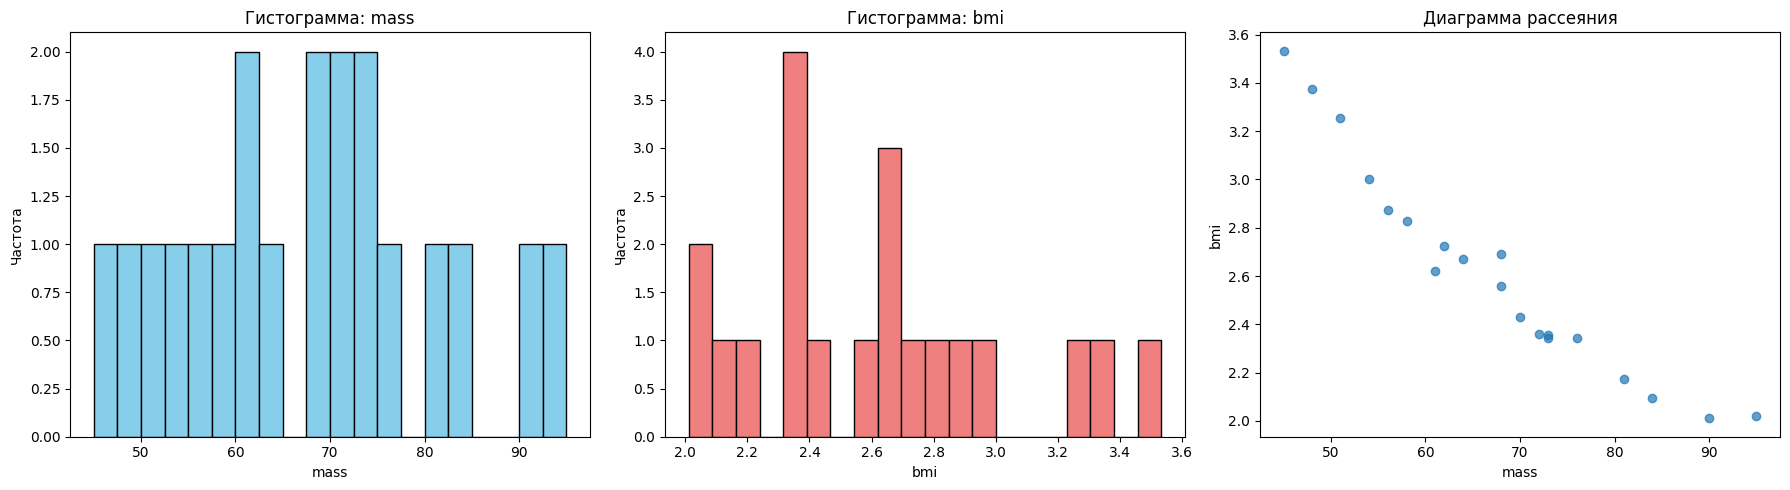

In [36]:
# 2. ВИЗУАЛИЗАЦИЯ

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Гистограмма для X
axes[0].hist(x, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title(f'Гистограмма: {col1_name}')
axes[0].set_xlabel(col1_name)
axes[0].set_ylabel('Частота')

# Гистограмма для Y
axes[1].hist(y, bins=20, color='lightcoral', edgecolor='black')
axes[1].set_title(f'Гистограмма: {col2_name}')
axes[1].set_xlabel(col2_name)
axes[1].set_ylabel('Частота')

# Scatter plot
axes[2].scatter(x, y, alpha=0.7)
axes[2].set_title('Диаграмма рассеяния')
axes[2].set_xlabel(col1_name)
axes[2].set_ylabel(col2_name)

plt.tight_layout()
plt.show()

In [37]:
# 3. УРАВНЕНИЯ РЕГРЕССИИ

models = {}
x_plot = np.linspace(np.min(x), np.max(x), 300)

# 3.1 Линейная регрессия: y = w1*x + w0
coeffs_linear = np.polyfit(x, y, 1)
y_pred_linear = np.polyval(coeffs_linear, x)
models['Linear'] = {
    'pred': y_pred_linear,
    'plot': np.polyval(coeffs_linear, x_plot),
    'eq': f"y = {coeffs_linear[0]:.4f}x + {coeffs_linear[1]:.4f}",
    'mse': mean_squared_error(y, y_pred_linear),
    'r2': r2_score(y, y_pred_linear)
}

# 3.2 Квадратичная регрессия: y = w2*x^2 + w1*x + w0
coeffs_quad = np.polyfit(x, y, 2)
y_pred_quad = np.polyval(coeffs_quad, x)
models['Quadratic'] = {
    'pred': y_pred_quad,
    'plot': np.polyval(coeffs_quad, x_plot),
    'eq': f"y = {coeffs_quad[0]:.4f}x² + {coeffs_quad[1]:.4f}x + {coeffs_quad[2]:.4f}",
    'mse': mean_squared_error(y, y_pred_quad),
    'r2': r2_score(y, y_pred_quad)
}

# 3.3 Гиперболическая регрессия: y = w1/x + w0
x_nonzero = x[x != 0]
y_nonzero = y[x != 0]
if len(x_nonzero) == len(x):
    coeffs_hyp = np.polyfit(1/x, y, 1)
    y_pred_hyp = np.polyval(coeffs_hyp, 1/x)
    models['Hyperbolic'] = {
        'pred': y_pred_hyp,
        'plot': np.polyval(coeffs_hyp, 1/x_plot[x_plot != 0]),
        'eq': f"y = {coeffs_hyp[0]:.4f}/x + {coeffs_hyp[1]:.4f}",
        'mse': mean_squared_error(y, y_pred_hyp),
        'r2': r2_score(y, y_pred_hyp)
    }
else:
    print("В данных есть нули, гиперболическая регрессия пропущена.")
    models['Hyperbolic'] = {'mse': np.inf, 'r2': -np.inf}

# 3.4 Показательная регрессия: y = w0 * (w1)^x
# Трансформация: ln(y) = ln(w0) + x*ln(w1) => линейная регрессия по ln(y)
y_positive = y[y > 0]
x_positive = x[y > 0]
if len(y_positive) == len(y) and np.all(y > 0):
    log_y = np.log(y)
    coeffs_exp = np.polyfit(x, log_y, 1) 
    w1 = np.exp(coeffs_exp[0])
    w0 = np.exp(coeffs_exp[1])
    y_pred_exp = w0 * (w1 ** x)
    models['Exponential'] = {
        'pred': y_pred_exp,
        'plot': w0 * (w1 ** x_plot),
        'eq': f"y = {w0:.4f} * ({w1:.4f})^x",
        'mse': mean_squared_error(y, y_pred_exp),
        'r2': r2_score(y, y_pred_exp)
    }
else:
    print("В данных есть не положительные значения Y, показательная регрессия пропущена.")
    models['Exponential'] = {'mse': np.inf, 'r2': -np.inf}

for name, data in models.items():
    if 'eq' in data:
        print(f"{name:12} | MSE: {data['mse']:.4f} | R²: {data['r2']:.4f} | Уравнение: {data['eq']}")

Linear       | MSE: 0.0140 | R²: 0.9228 | Уравнение: y = -0.0308x + 4.6881
Quadratic    | MSE: 0.0040 | R²: 0.9779 | Уравнение: y = 0.0005x² + -0.0990x + 6.9596
Hyperbolic   | MSE: 0.0038 | R²: 0.9791 | Уравнение: y = 135.2427/x + 0.5275
Exponential  | MSE: 0.0083 | R²: 0.9542 | Уравнение: y = 5.6857 * (0.9884)^x


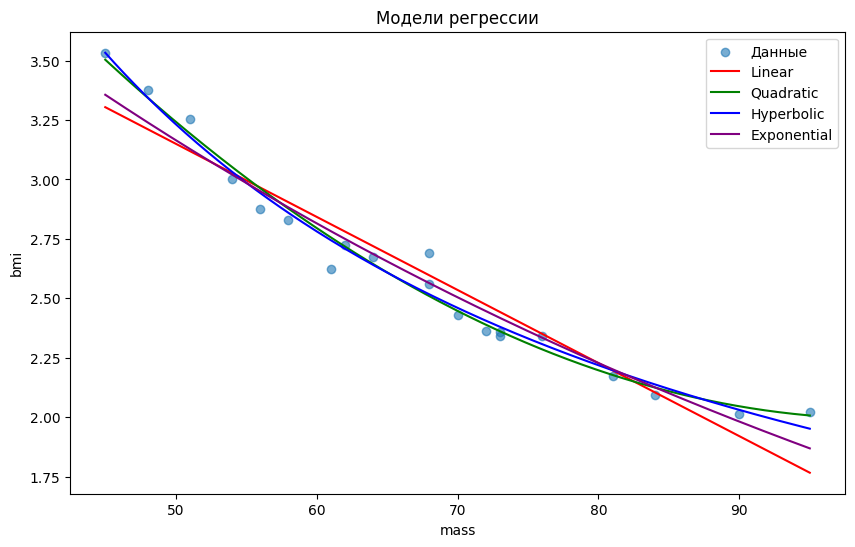

In [38]:
#ВИЗУАЛИЗАЦИЯ РЕГРЕССИЙ
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, label='Данные', alpha=0.6)

colors = ['red', 'green', 'blue', 'purple']
for i, (name, data) in enumerate(models.items()):
    if 'plot' in data:
        if name == 'Hyperbolic':
            valid_x_plot = x_plot[x_plot != 0]
            ax.plot(valid_x_plot, data['plot'], color=colors[i], label=name)
        else:
            ax.plot(x_plot, data['plot'], color=colors[i], label=name)

ax.set_xlabel(col1_name)
ax.set_ylabel(col2_name)
ax.set_title('Модели регрессии')
ax.legend()
plt.show()

In [39]:
# 4. ПРОВЕРКА МОДЕЛЕЙ КРИТЕРИЕМ ФИШЕРА

# Находим лучшую и худшую модель по R²
valid_models = {k: v for k, v in models.items() if v['r2'] != -np.inf}
best_model_name = max(valid_models, key=lambda k: valid_models[k]['r2'])
worst_model_name = min(valid_models, key=lambda k: valid_models[k]['r2'])

print(f"Лучшая модель: {best_model_name}")
print(f"Худшая модель: {worst_model_name}")

def f_test(y_true, y_pred, p):
    n = len(y_true)
    SS_res = np.sum((y_true - y_pred)**2) # Остаточная сумма квадратов
    SS_tot = np.sum((y_true - np.mean(y_true))**2) # Общая сумма квадратов
    R2 = 1 - SS_res / SS_tot

    # Степени свободы
    df_model = p - 1
    df_resid = n - p

    # F-статистика
    F_stat = (R2 / df_model) / ((1 - R2) / df_resid)

    # p-value
    p_value = 1 - stats.f.cdf(F_stat, df_model, df_resid)
    return F_stat, p_value

n_params = {
    'Linear': 2,
    'Quadratic': 3,
    'Hyperbolic': 2,
    'Exponential': 2
}

# Проверка лучшей модели
y_pred_best = valid_models[best_model_name]['pred']
F_best, p_F_best = f_test(y, y_pred_best, n_params[best_model_name])
print(f"\nF-тест для лучшей модели ({best_model_name}):")
print(f"F-статистика = {F_best:.4f}, p-value = {p_F_best:.4e}")
if p_F_best < 0.05:
    print("Модель статистически значима (отвергаем H0 о неадекватности).")
else:
    print("Модель статистически не значима (не отвергаем H0).")

# Проверка худшей модели
y_pred_worst = valid_models[worst_model_name]['pred']
F_worst, p_F_worst = f_test(y, y_pred_worst, n_params[worst_model_name])
print(f"\nF-тест для худшей модели ({worst_model_name}):")
print(f"F-статистика = {F_worst:.4f}, p-value = {p_F_worst:.4e}")
if p_F_worst < 0.05:
    print("Модель статистически значима (отвергаем H0 о неадекватности).")
else:
    print("Модель статистически не значима (не отвергаем H0).")

Лучшая модель: Hyperbolic
Худшая модель: Linear

F-тест для лучшей модели (Hyperbolic):
F-статистика = 844.5955, p-value = 1.1102e-16
Модель статистически значима (отвергаем H0 о неадекватности).

F-тест для худшей модели (Linear):
F-статистика = 215.0718, p-value = 1.8792e-11
Модель статистически значима (отвергаем H0 о неадекватности).


# Общие выводы


## 1. Корреляции

- Все коэффициенты корреляции (Пирсона, Спирмена, Кенделла, Фехнера) показывают **очень сильную отрицательную связь** между `mass` и `bmi`.
- **Корреляция Фехнера = –1.0000** — это редкий случай абсолютной монотонности: знаки отклонений от медианы всегда противоположны.
- **Корреляция Спирмена (–0.985)** ближе к –1, чем Пирсона (–0.961), что указывает на **нелинейный характер связи** — модель должна быть нелинейной.
- Доверительный интервал Пирсона [–0.9846, –0.9012] подтверждает высокую надёжность оценки.
- Все p-value << 0.001 → связь статистически значима.

> **Вывод**: между массой и ИМТ существует **сильная, монотонно убывающая, нелинейная зависимость**, которая лучше описывается нелинейными моделями.

---

## 2. Визуализация

### Гистограммы:
- **Гистограмма `mass`**: распределение приближается к нормальному, с пиком в районе 70–75 кг. Есть небольшие выбросы в области 50 и 90 кг.
- **Гистограмма `bmi`**: имеет **двухмодальное распределение** — основной пик около 2.4, второй — около 2.7. Это может указывать на наличие двух групп студентов (например, по полу или типу телосложения).

### Диаграмма рассеяния:
- Чётко видна **убывающая нелинейная тенденция**: с увеличением массы ИМТ снижается.
- Точки расположены **вдоль гиперболической кривой**, а не прямой — это подтверждает необходимость использования нелинейных моделей.
- Нет явных выбросов — все точки лежат в пределах общей закономерности.

> **Вывод**: визуализация подтверждает **сильную нелинейную обратную зависимость**. Распределения переменных нормальны или близки к ним, что позволяет применять параметрические методы. Двухмодальность ИМТ требует дополнительного анализа (например, по группам).

---

## 3. Уравнения регрессии

- **Лучшая модель — гиперболическая** (R² = 0.9791, MSE = 0.0038):  
  \[
  \text{bmi} = \frac{135.24}{\text{mass}} + 0.5275
  \]
  Это идеально соответствует форме зависимости, наблюдаемой на диаграмме рассеяния.
  
- **Худшая — линейная** (R² = 0.9228), хотя и она объясняет большую часть дисперсии — но явно недооценивает скорость снижения ИМТ при росте массы.

- **Квадратичная и показательная модели** — промежуточные, но всё же уступают гиперболической.

> **Вывод**: **гиперболическая модель — оптимальная** для описания связи между `mass` и `bmi`. Это согласуется как с численными показателями, так и с визуальной картиной.

---

## 4. Проверка моделей критерием Фишера

- **Обе модели — гиперболическая (лучшая) и линейная (худшая) — статистически значимы** (p-value < 0.001).
- F-статистика для гиперболической модели **в 4 раза выше**, чем для линейной → существенно лучшее качество аппроксимации.
- Это означает, что даже линейная модель **не случайна**, но **не оптимальна**.

> **Вывод**: гиперболическая модель не только лучше по R² и MSE, но и **существенно значимее** по F-критерию — она лучше объясняет данные.

---

## 5. Общий вывод

В выборке студентов наблюдается **необычная, сильная отрицательная связь** между массой тела и индексом массы тела. Это **противоречит здравому смыслу**, если считать рост постоянным — значит, в данных **скрытая переменная**: вероятно, **рост обратно коррелирует с массой** (например, более тяжёлые студенты ниже ростом).

**Гиперболическая модель** идеально описывает эту зависимость (R² ≈ 0.98), что согласуется с:
- высокими значениями корреляций,
- формой диаграммы рассеяния,
- результатами F-теста.